In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_modeling import *
from data_analysis import *

## Load data

In [3]:
# Load the forecasting model data 
data = pd.read_csv('../data/ml_data_panel.csv').dropna()

data = data.astype({'sector': 'category'})

labels = load_char_labels()
identifiers = ['tic', 'conm', 'year', 'month', 'date']
stock_chars, acc_ratios = labels['stock_chars'], labels['acc_ratios']
targets = ['target_exret']

acc_ratios.remove('rd_sale')
acc_ratios.remove('rd_me')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246873 entries, 0 to 247592
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   date           246873 non-null  int64   
 1   year           246873 non-null  int64   
 2   month          246873 non-null  int64   
 3   tic            246873 non-null  object  
 4   conm           246873 non-null  object  
 5   sector         246873 non-null  category
 6   subsector      246873 non-null  object  
 7   market_equity  246873 non-null  float64 
 8   dolvol_126d    246873 non-null  float64 
 9   turnover_126d  246873 non-null  float64 
 10  ivol_ff3_21d   246873 non-null  float64 
 11  ni_ivol        246873 non-null  float64 
 12  beta_60m       246873 non-null  float64 
 13  z_score        246873 non-null  float64 
 14  f_score        246873 non-null  float64 
 15  netdebt_me     246873 non-null  float64 
 16  ebit_bev       246873 non-null  float64 
 17  ebit_sale      

## Train and tune a light GBM model to forecast the returns

In [3]:
# Split the data into training, validation, and test sets
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(data[stock_chars + acc_ratios + ['sector']], 
                                                                data['target_exret'].values,
                                                                ratios =(0.6, 0.2, 0.2),
                                                                stratify = data['sector'],
                                                                seed = 42,
                                                                # time_series = False
                                                                )

In [4]:
# set parameters
params = {
    'objective': 'regression',
    'metric': ['r2', 'rmse', 'mae', 'huber'],
    'num_leaves': 250,
    'learning_rate': 0.1,
    'verbose': -1,
}
# n_estimators
num_boost_round = 500  

# declare categorical(s) and ensure dtype is 'category' across all splits
categorical_features = ['sector']

# fit the model
model, evals_result, importance_dict = fit_lightgbm_to_panel(
    X_train, y_train, X_valid, y_valid,
    params, num_boost_round, categorical_features
)


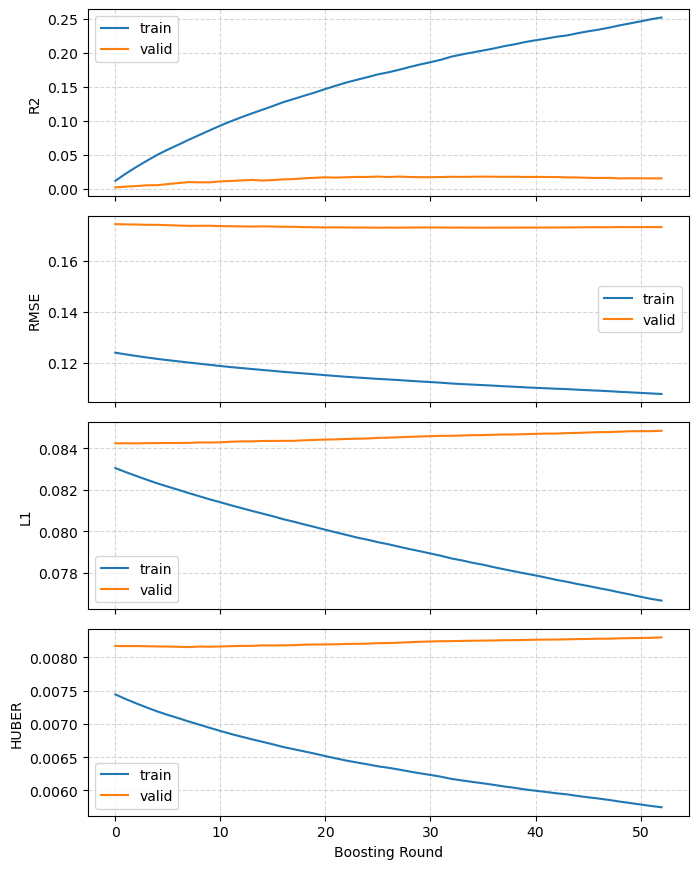

In [5]:
plot_metrics(evals_result)  # expects 'r2', 'rmse', 'mae', 'huber' logged

In [6]:
# make predictions on validation and test sets
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred_test  = model.predict(X_test,  num_iteration=model.best_iteration)

# Evaluate model performance
r2_valid, mse_valid, mae_valid = evaluate_model(y_valid, y_pred_valid)
print(f"Perf on the validation set: R2: {r2_valid}, MSE: {mse_valid}, MAE: {mae_valid}")

r2_test, mse_test, mae_test = evaluate_model(y_test, y_pred_test)
print(f"Perf on the test set: R2: {r2_test}, MSE: {mse_test}, MAE: {mae_test}")

Perf on the validation set: R2: 0.0037227320792787566, MSE: 0.03031140115168172, MAE: 0.08424288433065286
Perf on the test set: R2: 0.002968152252503242, MSE: 0.015081775453454321, MAE: 0.08382202709615319


## Evaluate Model

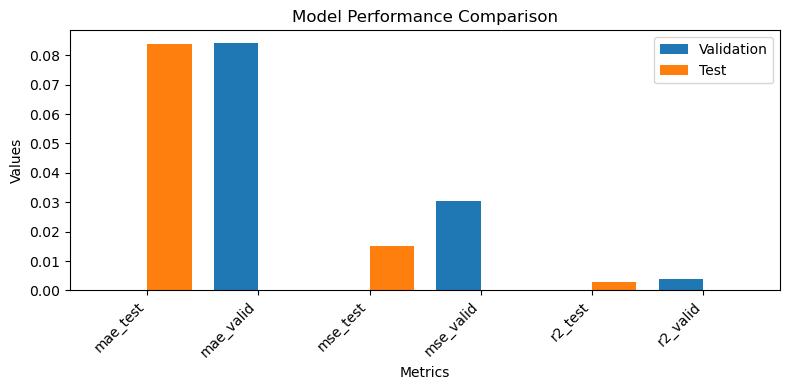

In [7]:
d1 = {'r2_valid': r2_valid, 'mse_valid': mse_valid, 'mae_valid': mae_valid}
d2 = {'r2_test': r2_test, 'mse_test': mse_test, 'mae_test': mae_test}
plot_dict([d1, d2], labels=['Validation', 'Test'], title="Model Performance Comparison", xlabel="Metrics", ylabel="Values")

## Inspect the predictive importance of the characteristics

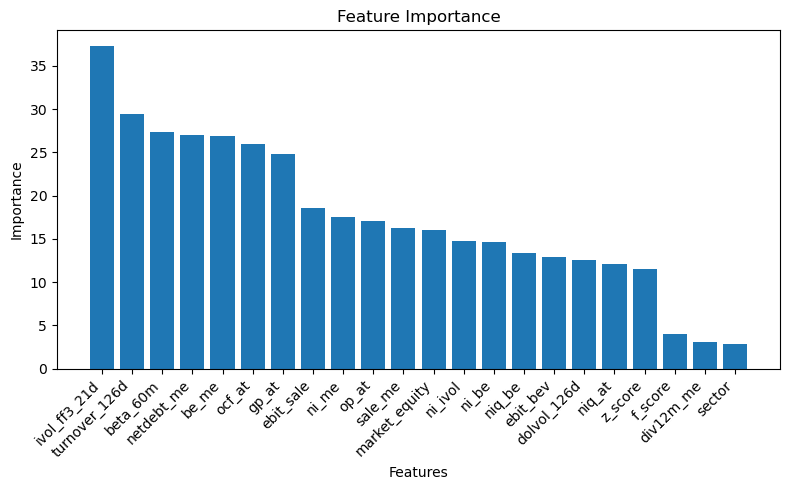

In [13]:
importance_dict = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

keys, values = zip(*importance_dict.items())
title="Feature Importance"
xlabel="Features"
ylabel="Importance"
plt.figure(figsize=(8, 5))
plt.bar(keys, values)
plt.xticks(rotation=45, ha="right")
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.tight_layout()
plt.show()

In [69]:
data['sector'].unique()

['Consumer Staples', 'Information Technology', 'Materials', 'Communication Services', 'Industrials', ..., 'Financials', 'Utilities', 'Energy', 'Health Care', 'Real Estate']
Length: 11
Categories (11, object): ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', ..., 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

## Outlier trimming

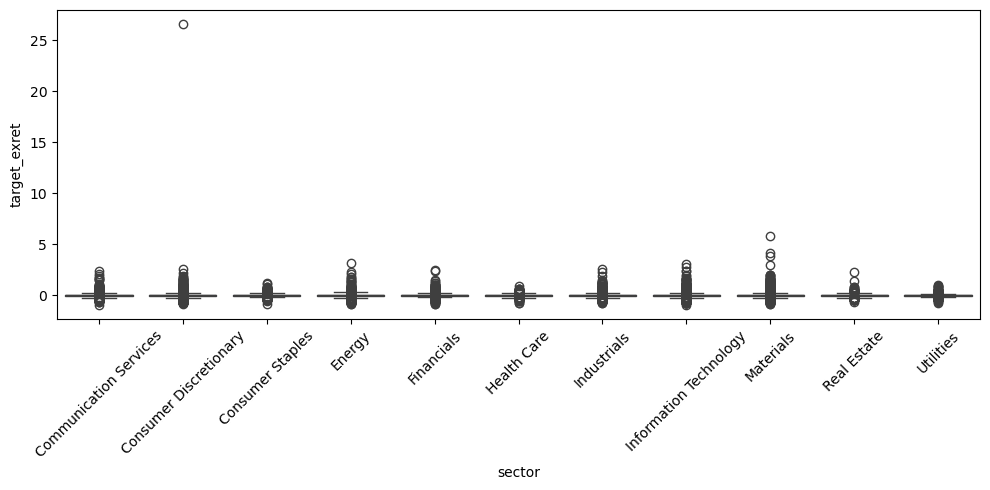

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
ax = sns.boxplot(data=data, x="sector", y="target_exret")
ax.set_xlabel("sector"); ax.set_ylabel("target_exret")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()


In [97]:
outlier_low_quantile = 0.1
#outlier_high_quantile = 1

# Alternatively (vectorized and faster):
thr_low = data.groupby('sector', observed=True)['target_exret'].transform(lambda s: s.quantile(outlier_low_quantile))
#thr_high = data.groupby('sector', observed=True)['target_exret'].transform(lambda s: s.quantile(outlier_high_quantile))

data_no_outliers = data.loc[(data['target_exret'] >= thr_low)]
                         #   & (data['target_exret'] <= thr_high)].copy()
data_no_outliers.tic.nunique()

1563

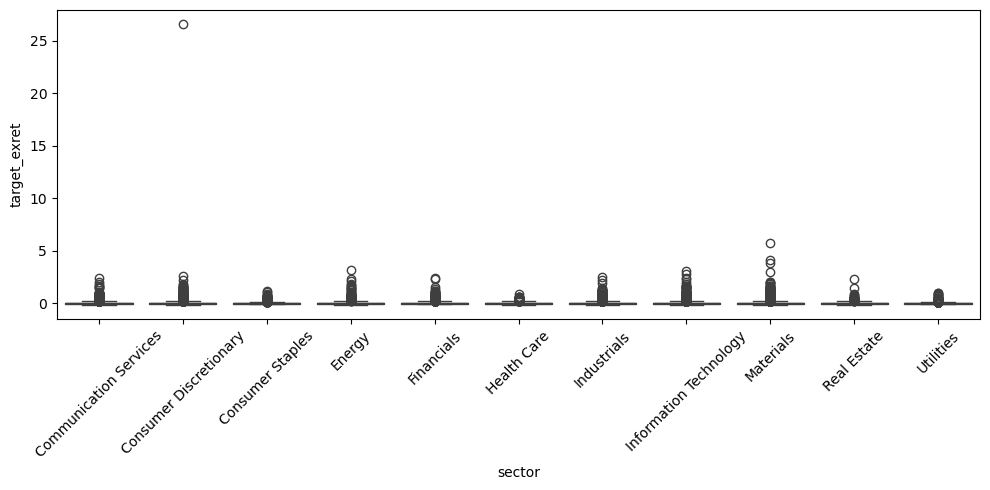

In [98]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=data_no_outliers, x="sector", y="target_exret")
ax.set_xlabel("sector"); ax.set_ylabel("target_exret")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()


In [16]:
data.loc[data['tic'].isin(data.loc[data['target_exret'] > 1].tic.to_list())]

,date,year,month,tic,conm,sector,subsector,market_equity,dolvol_126d,turnover_126d,...,niq_be,ocf_at,gp_at,niq_at,op_at,be_me,div12m_me,ni_me,sale_me,target_exret
6,20050228,2005,2,DJCO,DAILY JOURNAL CORP,Communication Services,Printing & Publishing (media tilt),66.231625,1.051835e+04,0.000190,...,0.073211,0.188884,0.557452,0.024464,0.180502,0.155515,0.000000,0.056333,0.525761,0.001799
16,20050228,2005,2,UIS,UNISYS CORP,Information Technology,"Business Services (incl. computer programming,...",2637.058318,1.663312e+07,0.005012,...,0.016881,0.107260,0.333148,0.004652,0.139200,0.583074,0.000000,0.070154,2.250348,-0.023256
22,20050228,2005,2,DXLG,DESTINATION XL GROUP INC,Consumer Discretionary,Apparel & Accessory Stores,191.463095,1.746078e+06,0.009607,...,-0.005444,0.016085,0.522856,-0.001443,0.082114,0.367193,0.000000,-0.048500,1.689960,0.034178
38,20050228,2005,2,MGM,MGM RESORTS INTERNATIONAL,Consumer Discretionary,Hotels & Lodging,10039.755759,5.106607e+07,0.006412,...,0.019595,0.072319,0.173890,0.007764,0.114474,0.438622,0.000000,0.036612,0.411889,0.031265
48,20050228,2005,2,MGPI,MGP INGREDIENTS INC,Industrials,Wholesale—Nondurable,121.128798,1.473883e+06,0.009955,...,0.002207,-0.031062,0.167080,0.001556,0.055356,1.065725,0.019737,0.060176,2.332203,0.007611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247513,20241231,2024,12,EBS,EMERGENT BIOSOLUTIONS INC,Materials,Chemicals & Allied,548.342074,2.191780e+07,0.046803,...,-0.405181,0.050875,0.314305,-0.156964,0.113908,0.767951,0.000000,-1.070500,2.010059,-0.059036
247526,20241231,2024,12,SMCI,SUPER MICRO COMPUTER INC,Information Technology,Industrial/Computer Machinery (incl. 357),19113.004443,1.703668e+09,0.130535,...,0.058352,-0.252997,0.213727,0.033538,0.174333,0.283430,0.000000,0.060308,0.784244,-0.069876
247542,20241231,2024,12,AROC,ARCHROCK INC,Utilities,"Electric, Gas & Sanitary Services",4487.445627,3.007492e+07,0.008750,...,0.038332,0.147619,0.221549,0.012927,0.175659,0.205419,0.024535,0.030935,0.234426,-0.032193
247565,20241231,2024,12,ERII,ENERGY RECOVERY INC,Information Technology,Industrial/Computer Machinery (incl. 357),900.830664,6.841067e+06,0.007426,...,-0.002972,0.144959,0.378272,-0.002628,0.168425,0.242568,0.000000,0.022827,0.148212,-0.058970


In [1]:
# Investigate some data transformation approach to uncorrelate variables and improve model performance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

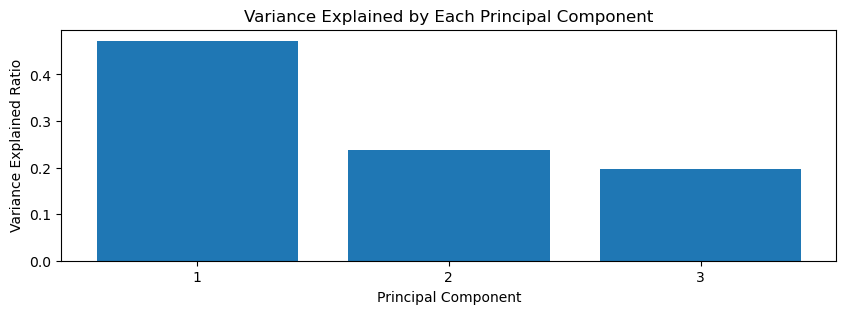

In [129]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes('number')
                                             .loc[:,['t_out','ta','rh','vel']])

n_components = 3
pca = PCA(n_components=n_components)

pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 3))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, n_components + 1))
plt.show()


In [130]:
np.sum(pca.explained_variance_ratio_)

0.9063419740682745

In [131]:
pca.components_

array([[ 0.60036586,  0.60394872,  0.28169393,  0.44210329],
       [-0.03507544,  0.27772896, -0.92483821,  0.2575085 ],
       [-0.43758071, -0.26226324,  0.1724528 ,  0.84261566]])